In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
from lmfit import Minimizer, Parameters, report_fit, Parameter, minimize, fit_report ,conf_interval2d
from scipy.special import gammaincinv
import emcee
import corner

In [57]:
# Read data and clean data

data = Table.read("outerdisk_sample.fits")
print(data.info)
rgc_origin = np.array(data["Rgc"])
Zfeh = np.array(data["feh"])
Zfeh_err = np.array(data["feh_err"])

isnan_rgc = np.isnan(rgc_origin)

rgc = rgc_origin[~isnan_rgc]
rgc_err = np.abs(rgc-8.34)*0.2
Zfeh = Zfeh[~isnan_rgc]
Zfeh_err = Zfeh_err[~isnan_rgc]

# sort according rgc
rgc_order = np.argsort(rgc)

rgc = rgc[rgc_order]
rgc_err = rgc_err[rgc_order]
Zfeh = Zfeh[rgc_order]
Zfeh_err = Zfeh_err[rgc_order]

# cutoff
dropratio = 0.95
num_remain = np.int(rgc.shape[0]*dropratio)

rgc = rgc[:num_remain]
rgc_err = rgc_err[:num_remain]
Zfeh = Zfeh[:num_remain]
Zfeh_err = Zfeh_err[:num_remain]

<Table length=23983>
       name        dtype    unit     class     n_bad
----------------- ------- ------- ------------ -----
             teff float32       K       Column     0
         teff_err float32       K       Column     0
              feh float32               Column     0
          feh_err float32               Column     0
               rv float32  km / s       Column     0
           rv_err float32  km / s       Column     0
             glon float64 degrees       Column     0
             glat float64 degrees       Column     0
     distK50_RJCE float64  parsec MaskedColumn   359
     distK15_RJCE float64  parsec MaskedColumn   359
     distK85_RJCE float64  parsec MaskedColumn   359
                X float64     kpc MaskedColumn   359
                Y float64     kpc MaskedColumn   359
                Z float64     kpc MaskedColumn   359
              Rgc float64     kpc MaskedColumn   359
             r_gc float64     kpc MaskedColumn   359
              PHI float64

/tmp/ipykernel_482/1498319388.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  num_remain = np.int(rgc.shape[0]*dropratio)


In [58]:
# likelihood of posterior
def ln_posterior(params,r,r_err,z,z_err):
    a = params[0]
    z_0= params[1]
    
    sigma_m = a*r_err
    sigma_z = z_err

    sigma_tot = np.sqrt(sigma_m**2+sigma_z**2)

    z_m = a*r+z_0
    
    L0 = np.sum(-(z-z_m)**2/(2*sigma_tot**2)-0.5*np.log(2.*np.pi)-np.log(sigma_tot))
    
    return L0

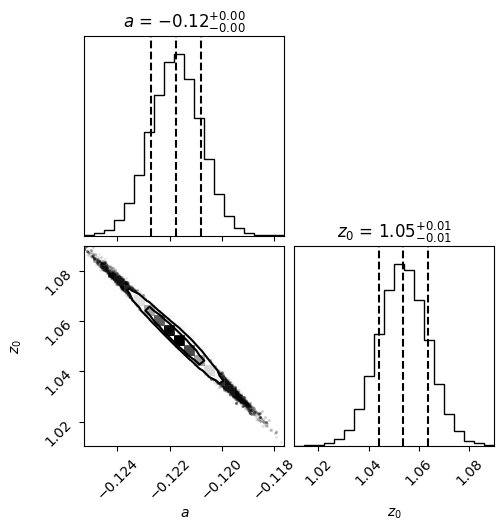

In [59]:
# MCMC
nwalker = 100
ndim = 2
p0 = np.zeros((nwalker,ndim))
p0[:,0] = np.random.rand(nwalker)
p0[:,1] = np.random.rand(nwalker)+1.


sampler = emcee.EnsembleSampler(nwalker, ndim, ln_posterior,args=[rgc,rgc_err,Zfeh,Zfeh_err])
pos,prob,stat = sampler.run_mcmc(p0,500)
sampler.reset()
sampler.run_mcmc(pos,1000)
samples = sampler.chain[:, :, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=[r'$a$',r'$z_0$',r"$\tau_z$"],quantiles=[0.16, 0.5, 0.84],show_titles=True, title_kwargs={"fontsize": 12})

[-0.12173763] [1.05384807]


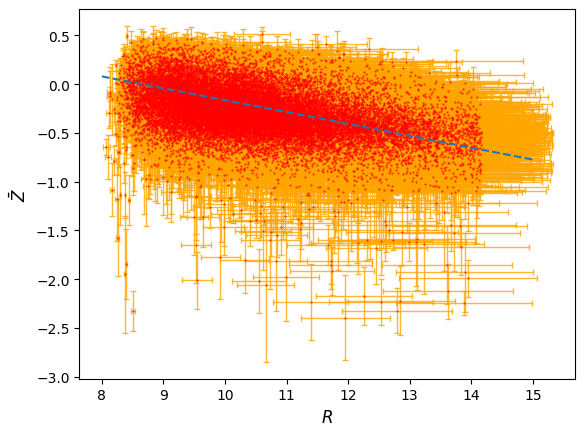

In [60]:
a_bayes = np.percentile(samples[:, 0],[50])
z0_bayes = np.percentile(samples[:, 1],[50])

print(a_bayes,z0_bayes)

r_line = np.linspace(8,15,100)
zmodel = a_bayes*r_line+z0_bayes

plt.figure()
plt.plot(r_line,zmodel,ls="--",zorder=1)
plt.errorbar(rgc,Zfeh,xerr=rgc_err,yerr=Zfeh_err,fmt='o',ecolor='orange',color='r',elinewidth=1,ms=0.5,capsize=2,alpha=0.8,zorder=0)
plt.xlabel(r'$R$',fontsize=12)
plt.ylabel(r'$\bar{Z}$',fontsize=12)
# plt.xscale("log")
plt.xlabel(r'$R$',fontsize=12)
plt.ylabel(r'$Z$',fontsize=12)
plt.show()

In [61]:
# groupby
print(np.max(rgc))
print(np.min(rgc))


14.160880368163586
8.072965657783511


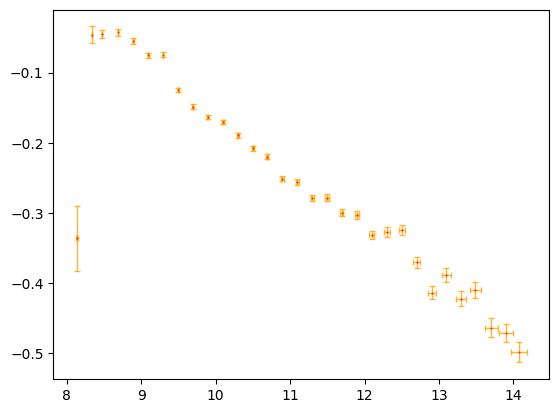

In [62]:
border = np.linspace(8,14.2,32)
bins = np.zeros(31)
r_center = np.zeros(31)
z_center = np.zeros(31)
sigmaZ_bottom = np.zeros(31)
Zmean_up = np.zeros(31)
sigmar_bottom = np.zeros(31)
rmean_up = np.zeros(31)

zstd = np.zeros(31)
rstd = np.zeros(31)
num_bin = np.zeros(31)

step = (14.2-8.)/31

posi_list = (rgc-8)//step

posi_list = posi_list.astype(int)

for index in range(31):
    r_center[index] = (border[index]+border[index+1])/2

for index in range(len(rgc)):
    sigmaZ_bottom[posi_list[index]] += 1/Zfeh_err[index]**2
    Zmean_up[posi_list[index]] += Zfeh[index]/Zfeh_err[index]**2
    sigmar_bottom[posi_list[index]] += 1/rgc_err[index]**2
    rmean_up[posi_list[index]] += rgc[index]/rgc_err[index]**2
    num_bin[posi_list[index]] += 1
    rstd[posi_list[index]] += 1/rgc_err[index]**2
    zstd[posi_list[index]] += 1/Zfeh_err[index]**2


zstd = 1/np.sqrt(zstd)
rstd = 1/np.sqrt(rstd)

Z_fin = Zmean_up/sigmaZ_bottom
R_fin = rmean_up/sigmar_bottom

plt.figure()
plt.errorbar(R_fin,Z_fin,xerr=rstd,yerr=zstd,fmt='o',ecolor='orange',color='r',elinewidth=1,ms=0.5,capsize=2,alpha=0.8,zorder=0)
plt.xlabel(r'$R$',fontsize=12)
plt.ylabel(r'$Z$',fontsize=12)
plt.show()


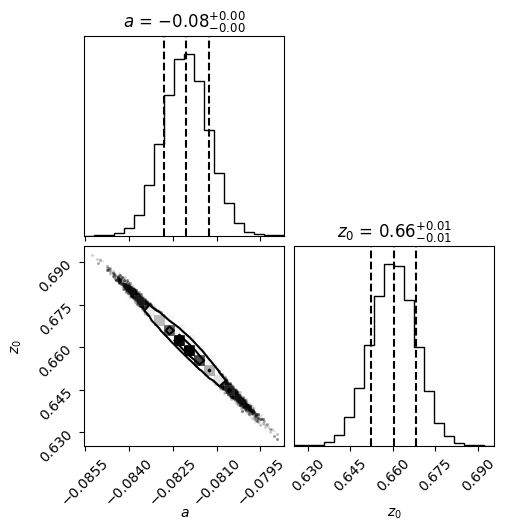

In [63]:
# MCMC
nwalker = 100
ndim = 2
p0 = np.zeros((nwalker,ndim))
p0[:,0] = np.random.rand(nwalker)
p0[:,1] = np.random.rand(nwalker)+1.


sampler = emcee.EnsembleSampler(nwalker, ndim, ln_posterior,args=[R_fin,rstd,Z_fin,zstd])
pos,prob,stat = sampler.run_mcmc(p0,500)
sampler.reset()
sampler.run_mcmc(pos,1000)
samples = sampler.chain[:, :, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=[r'$a$',r'$z_0$',r"$\tau_z$"],quantiles=[0.16, 0.5, 0.84],show_titles=True, title_kwargs={"fontsize": 12})

[-0.12173763] [1.05384807]


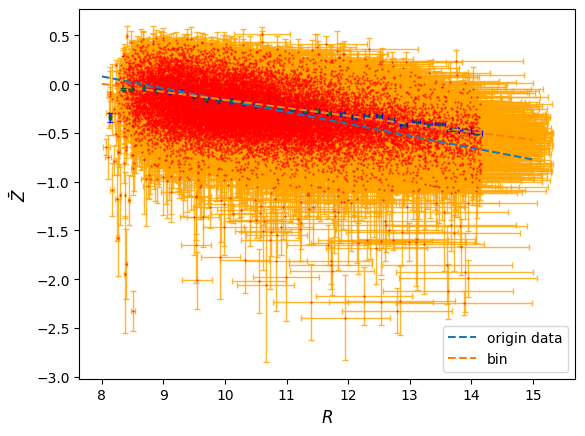

In [64]:
a_bayes_bin = np.percentile(samples[:, 0],[50])
z0_bayes_bin = np.percentile(samples[:, 1],[50])

print(a_bayes,z0_bayes)

r_line = np.linspace(8,15,100)
zmodel = a_bayes*r_line+z0_bayes
zmodel_bin = a_bayes_bin*r_line+z0_bayes_bin


plt.figure()
plt.plot(r_line,zmodel,ls="--",zorder=2,label="origin data")
plt.plot(r_line,zmodel_bin,ls="--",zorder=2,label="bin")
plt.errorbar(R_fin,Z_fin,xerr=rstd,yerr=zstd,fmt='o',ecolor='blue',color='green',elinewidth=1,ms=2,capsize=2,alpha=0.8,zorder=1)
plt.errorbar(rgc,Zfeh,xerr=rgc_err,yerr=Zfeh_err,fmt='o',ecolor='orange',color='r',elinewidth=1,ms=0.5,capsize=2,alpha=0.8,zorder=0)
plt.xlabel(r'$R$',fontsize=12)
plt.ylabel(r'$Z$',fontsize=12)
# plt.xscale("log")
plt.legend()
plt.show()